In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [21]:
#################
### CONSTANTS ###
#################

NA = 6.02214076e23 # Avogadro's number
Troom = 298.15 # Room temperature

# Cross sections and scattering/absorption trasmission coefficients

## Densities
First we need the molar masses $M[\frac{g}{mol}]$ of $H_2O$, $D_2O$, $C{10}D_{22}$ and $C_6D_6$.

In [22]:
M = {} # Molar mass
M['H2O'] = 18.01528 # g/mol
M['D2O'] = 20.0276
M['C3D8O3']  = 99.98
M['C3H8O3'] = 92.09382


Than, from the densities in $\frac{kg}{m^3}$, we can calculate the molar densities in $\frac{mol}{cm^3}$ as:
$$
n[\frac{mol}{cm^3}] = \frac{\rho[\frac{kg}{m^3}]}{M[\frac{g}{mol}]} \times 10^{3}/ 10^{6}
$$

In [23]:
# Molar density
rho = {} # moles/cm^3
rho['gly'] = pd.read_csv('./data/thermodynamic/density.csv', skiprows=0)
rho['gly']['rho'] = rho['gly']['rho'] / M['C3D8O3'] * M['C3D8O3']/M['C3H8O3']# density = mass / volume, M in g/mol
rho['d2'] = 1.11 / M['D2O'] # density = 1.11 g/cm^3, M in g/mol
rho['h2'] = 1 / M['H2O'] # density = 1 g/cm^3, M in g/mol

We fit the data to work with analytical expressions for the denitise.

rho = -2.076146803104599e-08 * T**2 + 2.9401571051129395e-06 * T + 0.014600038465097229


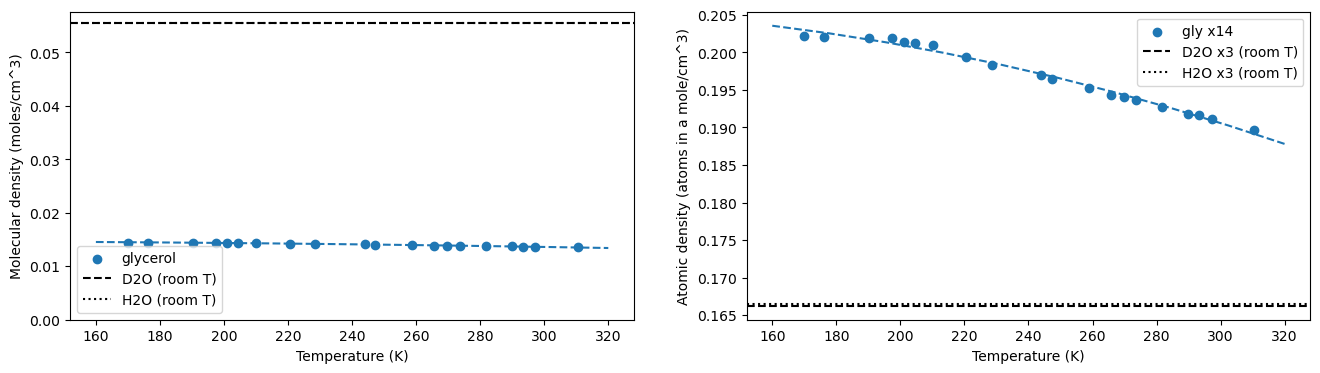

In [24]:
# Density plot
fig, ax = plt.subplots(1,2,figsize=(16, 4))
ax[0].scatter(rho['gly'].Temp, rho['gly'].rho, label='glycerol', color='C0')
ax[0].axhline(rho['d2'], color='k', linestyle='--', label='D2O (room T)')
ax[0].axhline(rho['h2'], color='k', linestyle=':', label='H2O (room T)')
# Linear Fit to work with an analytical expression
def linear(x, a, b, c):
    return a*x**2 + b*x + c
popt, pcov = curve_fit(linear, rho['gly'].Temp, rho['gly'].rho)
print('rho = {} * T**2 + {} * T + {}'.format(*popt))

rho_gly_anal = lambda T: -2.076146803104599e-08 * T**2 + 2.9401571051129395e-06 * T + 0.014600038465097229
X = np.linspace(160, 320,10)
ax[0].plot(X, rho_gly_anal(X), color='C0', linestyle='--')


ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('Molecular density (moles/cm^3)')
ax[0].set_ylim(0)
ax[0].legend()

ax[1].scatter(rho['gly'].Temp, rho['gly'].rho*14, label='gly x14')
ax[1].axhline(rho['d2']*3, color='k', linestyle='--', label='D2O x3 (room T)')
ax[1].axhline(rho['h2']*3, color='k', linestyle=':', label='H2O x3 (room T)')

ax[1].plot(X, rho_gly_anal(X)*14, color='C0', linestyle='--')

ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Atomic density (atoms in a mole/cm^3)')

ax[1].legend()

## Cross section
Starting from the **bound atomic cross sesctions** and the **measured cross sections for D2O and H2O** we buil up the non bounded cross sections for $C{10}D_{22}$ and $C_6D_6$. First we import the data: atomic bound cross sections for H, D, O, C, and the measured cross sections for D2O and H2O.

In [25]:
# Bound total scattering cross section [barn]
sigma = {}
sigma['D'] = 7.64 + 0.000519
sigma['H'] = 82.02 + 0.3326
sigma['O'] = 4.232 + 0.00019
sigma['C'] = 5.551 + 0.0035

### D2O and H2O cross section ###
cross = {}
cross['D2O'] = pd.read_csv('./data/thermodynamic/cross_section_D2O.dat', sep='\s+')
cross['H2O'] = pd.read_csv('./data/thermodynamic/cross_section_H2O.dat', sep='\s+')

We fit the D2O cross section to get an analitical (2nd order polinomial) function to work with:
$$
\sigma_{D2O}(E) = a + bE + cE^2
$$

a + b*x + c*x**2
Fit parameters: [ 1.53112713e+01 -3.87942317e-02  1.12174957e-04]


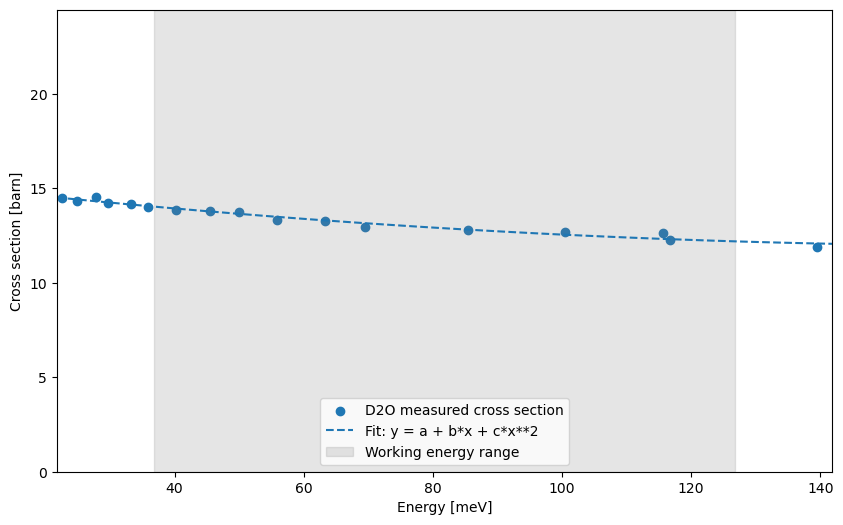

In [34]:
# Fit in the energy range of interest

plt.figure(figsize=(10, 6))
plt.scatter(cross['D2O']['E[meV]'], cross['D2O']['sigma[barn]'], label='D2O measured cross section')

plt.xlabel('Energy [meV]')
plt.ylabel('Cross section [barn]')
plt.ylim(0)

E_lims = [81.8-60, 81.8+60]
plt.xlim(E_lims[0], E_lims[1])
#plt.xscale('log')


# Fit of D2O cross section in the range of interest
f = lambda x, a, b, c: a + b*x + c*x**2

X = cross['D2O'][(cross['D2O']['E[meV]'] > E_lims[0]) & (cross['D2O']['E[meV]'] < E_lims[1])]['E[meV]']
Y = cross['D2O'][(cross['D2O']['E[meV]'] > E_lims[0]) & (cross['D2O']['E[meV]'] < E_lims[1])]['sigma[barn]']
popt, pcov = curve_fit(f, X, Y)
X = np.linspace(E_lims[0], E_lims[1], 100)
plt.plot(X, f(X, *popt), label='Fit: y = a + b*x + c*x**2', linestyle='--')

# energy range of interest
plt.axvspan(81.8-45, 81.8+45, alpha=0.2, color='gray', label='Working energy range')

plt.legend()


print("a + b*x + c*x**2")
print('Fit parameters:', popt)

Tham we can extract the non-bounded cross section for the deuteriumatoms as:
$$
\sigma_{D}(E) = (\sigma_{D2O}(E) - \sigma_{O, bound})/2
$$
And tha we build the Benzene and Decane (molecular) cross sections, assuming the "kind of bounding of the D atoms is siilar", as:
$$
\sigma_{C{3}D_{8}O_3}(E) = 8 \times \sigma_{D}(E) + 3 \times \sigma_{C} + 3 \times \sigma_{O}
$$


In [27]:
# Molecular cross sections
def sigma_d2(E):
    a, b, c = 1.53112713e+01, -3.87942317e-02,  1.12174957e-04
    return a + b*E + c*E**2

def sigma_Dnb(E): # Non-bound cross section of D
    return (sigma_d2(E)-sigma['O'])/2

def sigma_gly(E):
    return 8*sigma_Dnb(E) + 3*sigma['C'] + 3*sigma['O']

## Scattering lengths
Finally we can get the mus
$$ \mu[cm^{-1}] = \rho [moles/cm^3] *N_a \times \sigma [cm^2/particle] $$
where $\rho [moles/cm^3] *N_a$ is the molecular density.

In [28]:
mu_d2 = lambda E: sigma_d2(E)*1e-24 * rho['d2'] * NA
mu_gly= lambda E, T: sigma_gly(E)*1e-24 * rho_gly_anal(T) * NA

(0.0, 0.5674251385974247)

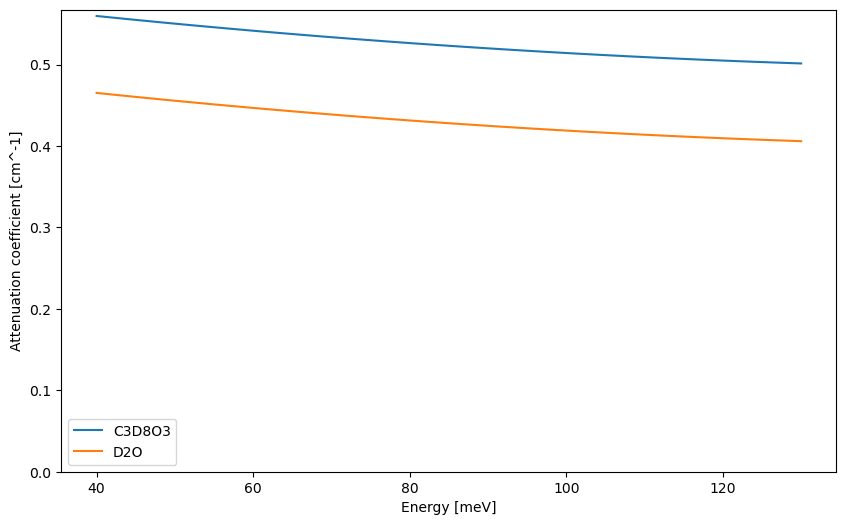

In [29]:
# plot mu
plt.figure(figsize=(10, 6))
E = np.linspace(40, 130, 100)
plt.plot(E, mu_gly(E, Troom), label='C3D8O3')
plt.plot(E, mu_d2(E), label='D2O')

plt.xlabel('Energy [meV]')
plt.ylabel('Attenuation coefficient [cm^-1]')
plt.legend()
plt.ylim(0)

### Compact everithing

In [30]:
from cross_sections import mu

mu['gly'](80,300)

0.5257874181080551

## Data for multiple scattering

In [31]:
E = 69.7

mu_gly = {}
for T in [160, 200, 300]:
    mu_gly[T] = mu['gly'](E, T)

print(mu_gly)

{160: 0.5694658219037616, 200: 0.5623623152915486, 300: 0.5332188873884528}
